In [3]:
import datetime
import xarray as xr
import numpy as np
import dask
import pandas as pd
import xwmb
import xwmt
import xgcm
import warnings
warnings.filterwarnings('ignore')
import cftime
print(xwmb.__version__, xwmt.__version__, xgcm.__version__)

0.2.2 0.2.2 0.8.2.dev15+g7492277


In [3]:
mt_path = "/pub/mariant3/WarmWaterMasses/data/"
labels = xr.open_dataset(f"{mt_path}ocetracv9/ocetrac-v9-blobs-tos-t1-r1-msq0-01860315-01891214-region.nc").blobs.rename('event_mask')

ids = np.unique(labels.values[~np.isnan(labels.values)])
#Because we want to run the budgets for all individual events, we will not get rid of 1 day events. Instead, we sort the events based on their area (largest to smallest)
# area_array = [(labels == id).any("time").sum(["xh", "yh"]).values for id in ids]
# ids = [id for _, id in sorted(zip(area_array, ids), reverse=True)]

mhw = 373

print('----------------- zooming into the each event -----------------')
event_mask = (labels == mhw)

# Zoom in on time period of event (+ 1 day before and 1 day after)
event_times = event_mask.time[event_mask.any(["xh", "yh"]).compute()]

window_size = min(7, len(event_times))

event_mask = event_mask.sel(time=slice(
    event_times[ 0],
    event_times[-1],
))
print('----------------- creating a 7-day dynamic mask -----------------')

# Create centered 3-day rolling cumulative mask
event_mask = (
    event_mask.rolling({"time":window_size}, min_periods=1, center=True)
    .max("time")
    .fillna(0.)
    .astype("float64")
)

print('----------------- merging and realigning-----------------')

# Merge budget diagnostics with the event mask
ds_event = xr.merge([ds, event_mask], join='inner')

# Get snapshots that bound the event
snap_event = snap.sel(
    time_bounds=slice(
        ds_event.time[0].values + datetime.timedelta(days = -1),
        ds_event.time[-1].values + datetime.timedelta(days = 1)
    )
)

ds_event = xr.merge([ds_event, snap_event, static], join='inner')

xh_mask = ds_event.event_mask.any(["time","yh"])
xh_mask_where = np.where(xh_mask)[0]
xh_mask = np.arange(xh_mask_where[0],xh_mask_where[-1]+1,1)

yh_mask = ds_event.event_mask.any(["time","xh"])
yh_mask_where = np.where(yh_mask)[0]
yh_mask = np.arange(yh_mask_where[0],yh_mask_where[-1]+1,1)

# Zoom in on region of the actual event
xh_event = ds_event.xh[xh_mask]
yh_event = ds_event.yh[yh_mask]

ds_event = ds_event.sel(xh=xh_event, yh=yh_event)

 # # # Realign tracer center/corner coordinates because inner "join" only shrinks the ("xh", "yh") dimensions!
xq_inner = ds_event.xq.sel(xq=slice(ds_event.xh[0], ds_event.xh[-1]))
xq_islice = (np.abs(ds_event.xq - xq_inner[0]).argmin().values - 1, np.abs(ds_event.xq - xq_inner[-1]).argmin().values + 2)
yq_inner = ds_event.yq.sel(yq=slice(ds_event.yh[0], ds_event.yh[-1]))
yq_islice = (np.abs(ds_event.yq - yq_inner[0]).argmin().values - 1, np.abs(ds_event.yq - yq_inner[-1]).argmin().values + 2)

ds_event = ds_event.isel(xq=slice(*xq_islice), yq=slice(*yq_islice))
print('----------------- Adding core coordinates of static to ds_event -----------------')

----------------- zooming into the each event -----------------
----------------- creating a 7-day dynamic mask -----------------
----------------- merging and realigning-----------------
----------------- Adding core coordinates of static to ds_event -----------------


In [4]:
def add_estimated_layer_interfaces(ds):
    return ds.assign_coords({"zi": xr.DataArray(
        np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
        dims=('zi',)
    )})
    
ds_event = add_estimated_layer_interfaces(ds_event)

ds_event = ds_event.assign_coords({
    "areacello": xr.DataArray(ds_event["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "yq": xr.DataArray(ds_event["yq"].values, dims=('yq',)),
    "deptho": xr.DataArray(ds_event["deptho"].values, dims=('yh', 'xh',)),
    "geolon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)),
    "geolat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)),
    "geolon_c": xr.DataArray(ds_event["geolon_c"].values, dims=('yq', 'xq',)),
    "geolat_c": xr.DataArray(ds_event["geolat_c"].values, dims=('yq', 'xq',)),
    })

coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'}
}

metrics = {
    ('X','Y'): "areacello", # Required for area-integration
    }

ds_event['tos'] = ds_event['thetao'].isel(zl=0)

In [5]:
import numpy as np
import regionate
import matplotlib.pyplot as plt
import warnings

print('----------------- creating _calc_temperature_wmt function -----------------')

def _calc_temperature_wmt(ds_event):
    lam = "heat"
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        grid = xgcm.Grid(ds_event.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)
        wm = xwmt.WaterMass(grid)
        
        import xbudget
        budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly").copy()
        del budgets_dict['salt']['lhs']
        del budgets_dict['salt']['rhs']
        
        xbudget.collect_budgets(grid, budgets_dict)
        
        wmb = xwmb.WaterMassBudget(
            grid,
            budgets_dict,
            ds_event.event_mask.squeeze() if ds_event.event_mask.squeeze().any() else None
            )
        wmb.mass_budget(lam, greater_than=True, default_bins=True)
    return wmb.wmt

def sel_times(ds, t):
    return ds.sel(
        time = t.expand_dims("time"),
        time_bounds = slice(
            t + datetime.timedelta(days = -1),
            t + datetime.timedelta(days = 1)
        )
    )
    
print('----------------- getting ready to define wmt -----------------')

wmt = xr.concat([
    _calc_temperature_wmt(sel_times(ds_event, t)).drop_dims("time_bounds")
    for t in ds_event.time
    ], dim="time")

# And the final bounds
wmt_bounds = xr.concat([
    _calc_temperature_wmt(sel_times(ds_event, t)).isel(time_bounds=0).drop_dims("time")
    for t in ds_event.time
    ], dim="time_bounds")
# And the final bounds
wmt_bounds = xr.concat([
    wmt_bounds,
    _calc_temperature_wmt(sel_times(ds_event, ds_event.time[-1])).isel(time_bounds=1).drop_dims("time")
], dim="time_bounds")

wmt_bounds_after = xr.concat([
    _calc_temperature_wmt(sel_times(ds_event, t)).isel(time_bounds=1).drop_dims("time")
    for t in ds_event.time
    ], dim="time_bounds")

# display(wmt)
# start = wmt.time.values.astype('datetime64[D]')[0]
# end = wmt.time.values.astype('datetime64[D]')[-1]
# print(f'Event {mhw} starts on {start} and ends on {end}')
# print(wmt.time.values)

print('----------------- getting ready to load wmt -----------------')
wmt.load()
wmt_bounds.load()
wmt_bounds_after.load()

print('-----------------loaded wmt -----------------')
# print('saving nc file...')
# print(f"wmt_mhw_event_full.to_netcdf(f'/pub/mariant3/WarmWaterMasses/data/budgets/rolling_budgets/rolling_budgets_v9/event-roll-budget_id-{int(mhw)}-{start}-{end}.nc'), mode='w'")
# wmt.to_netcdf(f'/pub/mariant3/WarmWaterMasses/data/budgets/rolling_budgets/rolling_budgets_v9/event-roll-budget_id-{int(mhw)}_{start}-{end}.nc', mode='w')
# print(f'...saved nc file for mhw {mhw}!')

----------------- creating _calc_temperature_wmt function -----------------
----------------- getting ready to define wmt -----------------
----------------- getting ready to load wmt -----------------
-----------------loaded wmt -----------------


Text(0, 0.5, 'Mass [kg]')

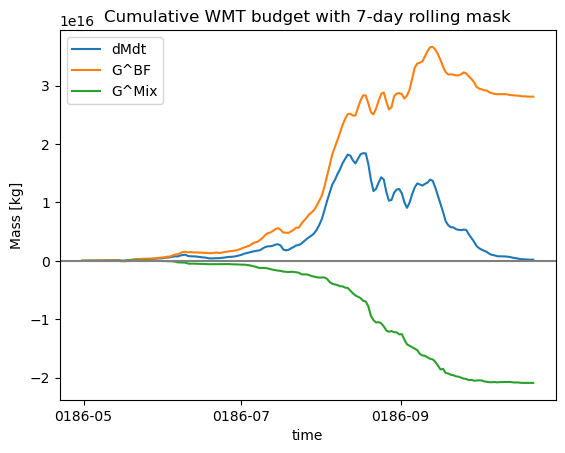

In [12]:
(wmt.mass_tendency.sel(thetao_l_target=29, method="nearest").cumsum("time")*86400).plot(label="dMdt")
(wmt.boundary_fluxes.sel(thetao_l_target=29, method="nearest").cumsum("time")*86400).plot(label="G^BF")
(wmt.diffusion.sel(thetao_l_target=29, method="nearest").cumsum("time")*86400).plot(label="G^Mix")
plt.axhline(0., color="gray")
plt.title("Cumulative WMT budget with 7-day rolling mask")
plt.legend()
plt.ylabel("Mass [kg]")

In [14]:
# wmt.to_netcdf("../data/wmt_id-373_07-day.nc")